# From Grocery Flyers to Plate: Cooking Up Meal Plans with LLM Agents using LangGraph

In [ ]:
#%%
import pdfplumber
import json
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
import ollama 
import re
from graphviz import Digraph

## Helper function

Define local LLM model on Ollama to be used, smaller model for easier tasks

In [ ]:
#%%
# A helper wrapper 
SMALL_MODEL = "deepseek-r1:latest"
BIG_MODEL = "deepseek-r1:14b" 

def ask_llm(prompt: str, model: str = SMALL_MODEL, options: dict = None) -> str:
    """A wrapper to get response from LLM and content cleanup to remove thinking part"""
    response = ollama.chat(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        options=options or {"temperature": 0}
    )
    content = response.get("message", {}).get("content", "")
    return re.sub(r"<think>.*?</think>", "", content, flags=re.DOTALL).strip()

## Processor

To read the flyer and pull out the useful info from a PDF grocery flyer

In [ ]:
#%%
# Processor 
class PDFProcessor:
    """Class to process PDF files and extract discounts"""

    def __init__(self):
        self.discounts = []

    def extract_text(self, pdf_path: str) -> str:
        """Extract text from the PDF file"""
        with pdfplumber.open(pdf_path) as pdf:
            return "\n".join(page.extract_text() for page in pdf.pages)

    def classify_flyer(self, text: str) -> str:
        """Classify the text as grocery or general"""

        prompt = f"""Classify this document as either a grocery store flyer with food discounts or a general document.
        Respond EXCLUSIVELY with JSON format: {{"classification": "grocery" | "general"}}
        ß
        Document: {text}
        
        JSON response:"""
        
        response = ask_llm(prompt, model=SMALL_MODEL)  
        json_str = re.search(r'{\s*"classification"\s*:\s*"(grocery|general)"\s*}', response)
        result = json.loads(json_str.group())

        return result["classification"]

    def parse_discounts(self, text: str) -> list[dict]:
        """Extract products on discount from the text"""

        prompt = f"""Analyze this sales flyer text and extract products on discount.
            Return JSON format with: product and category. 

            Text:
            {text}

            Return valid JSON array in the format:
            [{{"product": str, "category": str}}, ...]"""

        content = ask_llm(prompt, model=SMALL_MODEL)

        # Try to extract JSON from any surrounding text
        match = re.search(r'(\[.*\])', content, re.DOTALL)

        if match:
            content = match.group(1)

        try:
            return json.loads(content)
        except json.JSONDecodeError:
            return []

## Langchain Workflow 

After a router function to decide where to go next based on the classification, agent 1 will do generate_discount_summary and agent 2 will do generate_meal_plan.

In [ ]:
#%%

# StateGraph
class WorkflowState(TypedDict):
    """State for the workflow"""
    pdf_text: str
    classification: Literal["grocery", "general"] | None
    discounts: list[dict] | None
    summary: str | None
    meal_plan: str | None
    user_message: str | None


def router(state: WorkflowState) -> Literal["grocery", "general"]:
    """Route the workflow based on classification"""
    return "error" if state["classification"] is None else state["classification"]


class GroceryAgents:
    """Agents for processing grocery store flyers"""

    @staticmethod
    def generate_discount_summary(state: WorkflowState) -> WorkflowState:
        """Generate a summary"""

        prompt = f"""Create a concise summary of these grocery discounts:
        {json.dumps(state['discounts'], indent=2)}

        Include just product names and categories.
        Use bullet points and emojis for readability."""
        return {**state, "summary": ask_llm(prompt,model=SMALL_MODEL)}

    @staticmethod
    def generate_meal_plan(state: WorkflowState) -> WorkflowState:
        """Generate a meal plan and a shopping list"""

        discount_items = [d["product"] for d in state["discounts"]]
        prompt = f"""Create a one person's 3-day meal plan that tries to use as many of the discounted items as possible, but feel free to use other incredients when necessary: {', '.join(discount_items)}.
            Include:
            - Lunch and dinner recipes with ingredients, instructions and cooking time
            - Nutritional information for each meal that shows estimation for calories, protein, carbs, and fat
            - A final shopping list with quantities according to the 3-day meal plan
            """
        return {**state, "meal_plan": ask_llm(prompt,model=BIG_MODEL)}

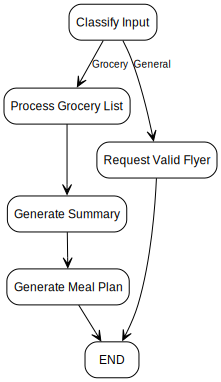

In [ ]:
#%%
# workflow
def create_workflow():
    """Create the workflow for processing grocery store flyers"""

    processor = PDFProcessor()
    workflow = StateGraph(WorkflowState)

    # Nodes 
    workflow.add_node("classify", lambda state: {
        **state, 
        "classification": processor.classify_flyer(state["pdf_text"])})
    
    workflow.add_node("process_grocery", lambda state: {
        **state,
        "discounts": processor.parse_discounts(state["pdf_text"])})
    
    workflow.add_node("generate_summary", GroceryAgents.generate_discount_summary)
    workflow.add_node("generate_meals", GroceryAgents.generate_meal_plan)
    workflow.add_node("request_valid_flyer", lambda state: {
        **state, 
        "user_message": "Please upload a valid grocery store flyer with food discounts."})

    # Graph 
    workflow.set_entry_point("classify")
    workflow.add_conditional_edges(
        "classify",
        router,
        {"grocery": "process_grocery", "general": "request_valid_flyer"}
    )
    workflow.add_edge("process_grocery", "generate_summary")
    workflow.add_edge("generate_summary", "generate_meals")
    workflow.add_edge("generate_meals", END)
    workflow.add_edge("request_valid_flyer", END)

    return workflow.compile()


# plot the workflow
dot = Digraph(graph_attr={'rankdir': 'TB'},
              node_attr={'shape': 'box', 'style': 'rounded', 'fontname': 'Arial', 'fontsize': '12'},
              edge_attr={'arrowhead': 'vee', 'fontname': 'Arial', 'fontsize': '10'})

dot.node("classify", label="Classify Input")
dot.node("process_grocery", label="Process Grocery List")
dot.node("generate_summary", label="Generate Summary")
dot.node("generate_meals", label="Generate Meal Plan")
dot.node("request_valid_flyer", label="Request Valid Flyer")
dot.node("END")

dot.edge("classify", "process_grocery", label="Grocery")
dot.edge("classify", "request_valid_flyer", label="General")

dot.edge("process_grocery", "generate_summary")
dot.edge("generate_summary", "generate_meals")
dot.edge("generate_meals", "END")
dot.edge("request_valid_flyer", "END")

dot

## Execution

In [ ]:
#%%

# run the workflow
if __name__ == "__main__":
    processor = PDFProcessor()
    workflow = create_workflow()
    
    results = workflow.invoke({
        "pdf_text": processor.extract_text("discounts.pdf"),
        "classification": None,
        "discounts": None,
        "summary": None,
        "meal_plan": None,
        "user_message": None
    })

    if results["user_message"]:
        print(results["user_message"])
    else:
        print("🛒 Discount Items Summary:")
        print(results["summary"])
        print("\n🍴 Shopping List and Meal Plan:")
        print(results["meal_plan"])

🛒 Discount Items Summary:
- Röda äpplen 🍎 (Frukt & Grön)  
- Blåbär 🍄 (Frukt & Grön)  
- Aubergine 🥄 (Blåbär & Grön)  
- Paprika röd 🔴 (Kryck & Papper)  
- Dalsjöfors 🥅 (Kylvaror)  
- Kylvara 🥖 (Kylvaror)

🍴 Shopping List and Meal Plan:
### 3-Day Meal Plan Using Discounted Ingredients

**Day 1:**

- **Breakfast:** Oatmeal with Red Apples and Blueberries  
  - *Ingredients:* Oats, milk, red apples, blueberries, honey, cinnamon.  
  - *Instructions:* Cook oats, add toppings.  
  - *Nutrition:* ~300 kcal, 5g protein, 45g carbs, 2g fat.

- **Lunch:** Aubergine and Red Pepper Stir-Fry with Tofu  
  - *Ingredients:* Aubergine, red peppers, tofu, soy sauce, garlic.  
  - *Instructions:* Stir-fry vegetables and tofu, serve with pickles.  
  - *Nutrition:* ~400 kcal, 15g protein, 20g carbs, 8g fat.

- **Dinner:** Eggplant and Red Pepper Curry  
  - *Ingredients:* Aubergine, red peppers, coconut milk, curry powder, rice.  
  - *Instructions:* Cook curry with aubergine and peppers, serve with ric